# Part 1: Define an RL Environment

In [179]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np

In [180]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):

        self.observation_space = spaces.Discrete(9)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 10

        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 10
        self.state[tuple(self.goal_pos)] = 8
        self.state[tuple([3,0])] = 2
        self.state[tuple([1,1])] = 4
        self.state[tuple([0,2])] = 4
        self.state[tuple([2,2])] = 6

        
    def reset(self, **kwargs):
        self.index = 0
        self.timestep = 0
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 10
        self.state[tuple(self.goal_pos)] = 8
        self.state[tuple([3,0])] = 2
        self.state[tuple([1,1])] = 4
        self.state[tuple([0,2])] = 4
        self.state[tuple([2,2])] = 6
        observation = self.state.flatten()

        info = {}

        return self.index
    
    def step(self, action):
        past = self.state.flatten()
        if action == 0:
          self.agent_pos[0] += 1
          move = 'down'
        if action == 1:
          self.agent_pos[0] -= 1
          move = 'up'
        if action == 2:
          self.agent_pos[1] += 1
          move = 'right'
        if action == 3:
          self.agent_pos[1] -= 1
          move = 'left'

        self.agent_pos = np.clip(self.agent_pos, 0, 3)

        self.state = np.zeros((4,4))
        self.state[tuple([3,0])] = 2
        self.state[tuple([1,1])] = 4
        self.state[tuple([0,2])] = 4
        self.state[tuple([2,2])] = 6
        self.state[tuple(self.agent_pos)] = 10
        self.state[tuple(self.goal_pos)] = 8
        observation = self.state.flatten()
        reward = 0
        if np.array_equal(observation, past):
           reward = 0
        elif np.array_equal(self.agent_pos, self.goal_pos):
          reward = 10
        elif np.array_equal(self.agent_pos, [1,1]):
           reward = -2
        elif np.array_equal(self.agent_pos, [3,0]):
           reward = -5
        elif np.array_equal(self.agent_pos, [2,2]):
           reward = 2
        elif np.array_equal(self.agent_pos, [0,2]):
           reward = -2
        
        self.timestep += 1

        terminated = False
        if reward == 10:
           terminated = True
        if self.timestep > self.max_timesteps:
           terminated = True
        truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 3)) else False

        self.index = self.agent_pos[0]*4+self.agent_pos[1]

        info = "Current position is: " + str(self.agent_pos) +'\nCUrrent Index:'+str(self.index) + "\nAction taken was: " + str(move) + "\nReward is: " + str(reward)
        
        return self.index, reward, terminated, info
        
    def render(self):
        output_grid = plt.grid(which = "minor")
        plt.xticks([0,1,2,3])
        plt.yticks([0,1,2,3])
        plt.imshow(self.state)

In [181]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self):
    return np.random.choice(self.action_space.n)

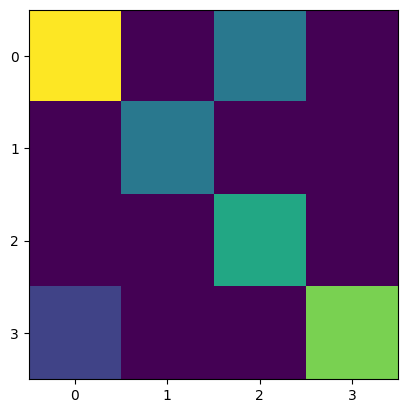

In [182]:
env = GridEnvironment()
agent = RandomAgent(env)

env.reset()

terminated, truncated = False, False
output_grid = plt.grid(which = "minor")
plt.xticks([0,1,2,3])
plt.yticks([0,1,2,3])
env.render()


Current position is: [0 0]
CUrrent Index:0
Action taken was: left
Reward is: 0


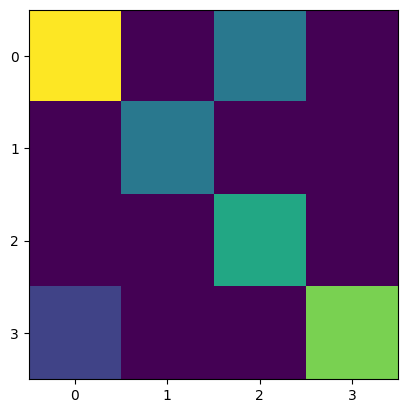

In [183]:
print(env.step(agent.step())[3])
env.render()

Current position is: [0 0]
CUrrent Index:0
Action taken was: up
Reward is: 0


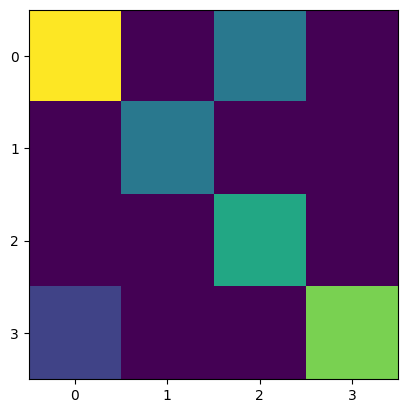

In [184]:
print(env.step(agent.step())[3])
env.render()

Current position is: [0 0]
CUrrent Index:0
Action taken was: left
Reward is: 0


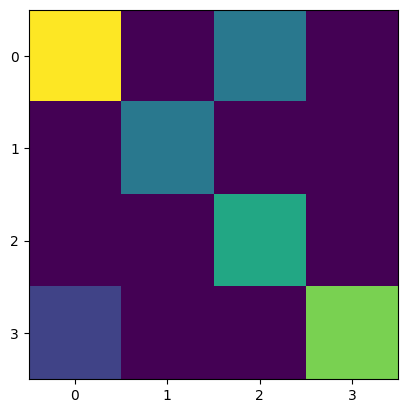

In [185]:
print(env.step(agent.step())[3])
env.render()

Current position is: [0 1]
CUrrent Index:1
Action taken was: right
Reward is: 0


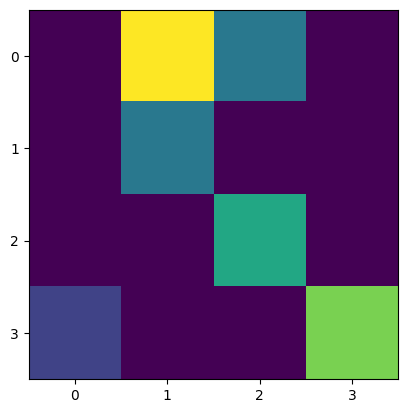

In [186]:
print(env.step(agent.step())[3])
env.render()

Current position is: [0 1]
CUrrent Index:1
Action taken was: up
Reward is: 0


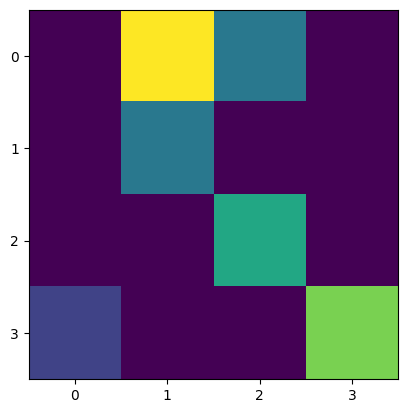

In [187]:
print(env.step(agent.step())[3])
env.render()

Current position is: [0 2]
CUrrent Index:2
Action taken was: right
Reward is: -2


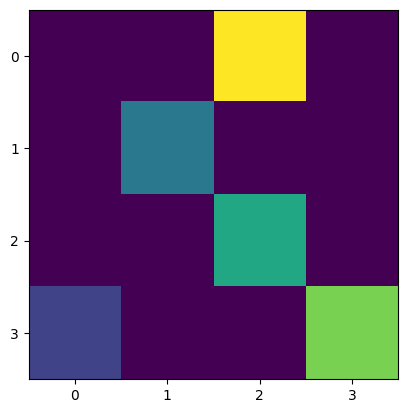

In [188]:
print(env.step(agent.step())[3])
env.render()

Current position is: [0 1]
CUrrent Index:1
Action taken was: left
Reward is: 0


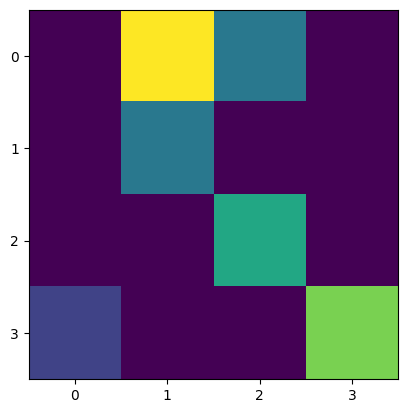

In [189]:
print(env.step(agent.step())[3])
env.render()

Current position is: [1 1]
CUrrent Index:5
Action taken was: down
Reward is: -2


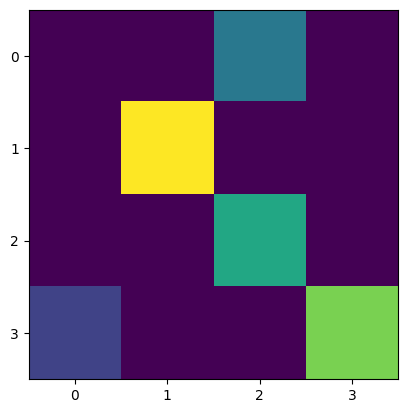

In [190]:
print(env.step(agent.step())[3])
env.render()

Current position is: [1 0]
CUrrent Index:4
Action taken was: left
Reward is: 0


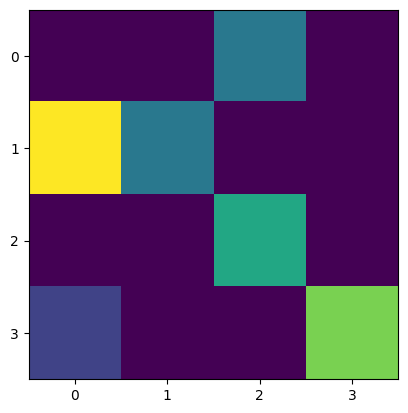

In [191]:
print(env.step(agent.step())[3])
env.render()

# Part 2: Solve your environment using - SARSA

In [192]:
epsilons = [0.1,0.2,0.3,0.4,0.5]
eps_decays = [0.0001,.0002,.0003,.0004,.0005]
episodes = 1000
max_steps_s = [8,9,10,11,12]
alpha = 0.85
gamma = 0.9



In [193]:
#Choose Action
def choose_action(state,epsilon):
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state, :])
    return action

#Update Q
def update(state1, state2, reward, action, action2):
    predict = Q[state1, action]
    target = reward + gamma * Q[state2, action2]
    Q[state1, action] = Q[state1, action] + alpha * (target - predict)

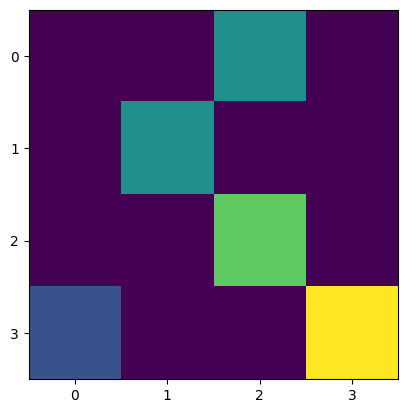

In [194]:
best_epsilon = 0
best_eps_decay = 0
best_max_steps = 0

best_reward = 0 
best_reward_list = []

for epsilon in epsilons:
    for eps_decay in eps_decays:
            for max_steps in max_steps_s:

                #Initializing the reward
                current_eps = epsilon
                reward_val=0
                reward_list = []
                time_list = []
                Q = np.zeros((16, 4))
                
                #SARSA
                for episode in range(episodes):
                    t = 0
                    env.reset()
                    reward_val = 0
                    state1 = 0
                    action1 = choose_action(state1,epsilon)

                    if epsilon > 0.01:
                        epsilon -= eps_decay
                
                    while t < max_steps:
                        # #Visualizing the training
                        # env.render()
                        
                        #Take a time step
                        state2, reward, done, info = env.step(action1)
                
                        #choose next action
                        action2 = choose_action(state2,epsilon)
                        
                        #update Q vals
                        update(state1, state2, reward, action1, action2)

                        #keep track of current state
                        state1 = state2
                        action1 = action2
                        
                        #Updating the respective values
                        t += 1
                        reward_val += reward

                        #If at the end of learning process
                        if done:
                            break
                    reward_list.append(reward_val)
                    time_list.append(t)
                if reward_val > best_reward:
                     best_reward = reward_val
                     best_epsilon = current_eps
                     best_eps_decay = eps_decay
                     best_max_steps = max_steps
                     best_reward_list = reward_list
                     best_time_list = time_list

                env.render()

In [195]:
print ("Performance : ", sum(best_reward_list)/episodes)
print("Average number of time steps : ", sum(best_time_list)/episodes)
print(best_reward,best_epsilon,best_eps_decay,best_max_steps)

Performance :  8.048
Average number of time steps :  5.592
12 0.009999999999998167 0.0003 8


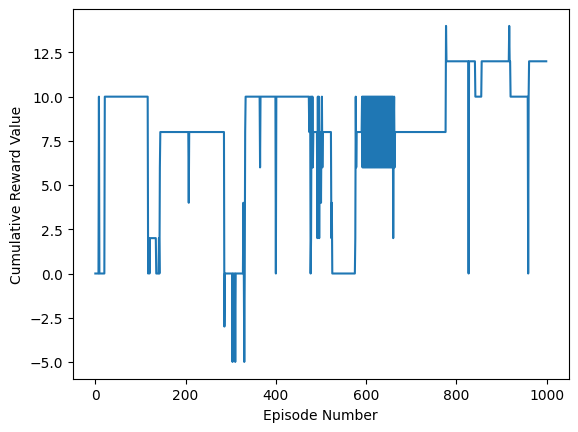

In [196]:
import matplotlib.pyplot as plt
plt.plot(list(range(episodes)),best_reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

In [197]:
epsilon = 0.5
episodes = 1000
max_steps = 10
alpha = 0.5
gamma = 0.9

Q = np.zeros((16, 4))

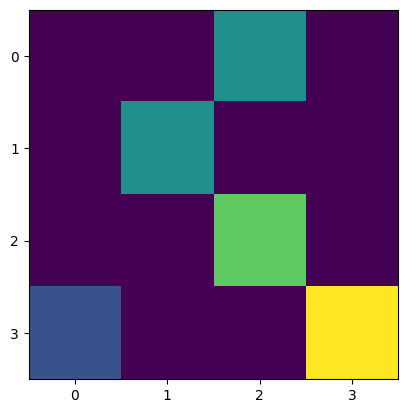

In [198]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    action1 = choose_action(state1,epsilon)
    reward_val = 0
 
    while t < max_steps:
        # #Visualizing the training
        # env.render()
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
 
        #choose next action
        action2 = choose_action(state2,epsilon)
         
        #update Q vals
        update(state1, state2, reward, action1, action2)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward
         
        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)

env.render()

Performance :  9.323
Average number of time steps :  4.151


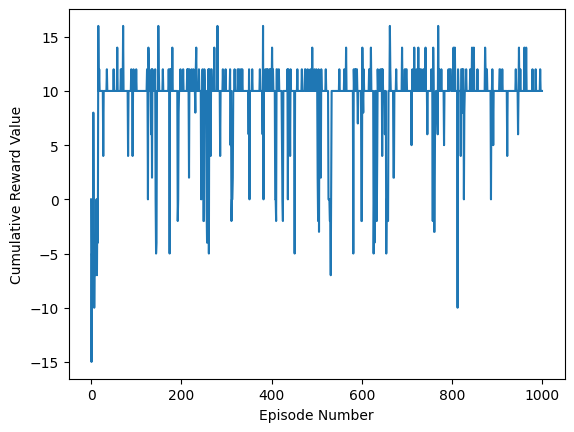

In [199]:
import matplotlib.pyplot as plt
print ("Performance : ", sum(reward_list)/episodes)
print("Average number of time steps : ", sum(time_list)/episodes)
plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

In [200]:
epsilon = 0.1
episodes = 1000
max_steps = 10
alpha = 0.6
gamma = 0.95

Q = np.zeros((16, 4))

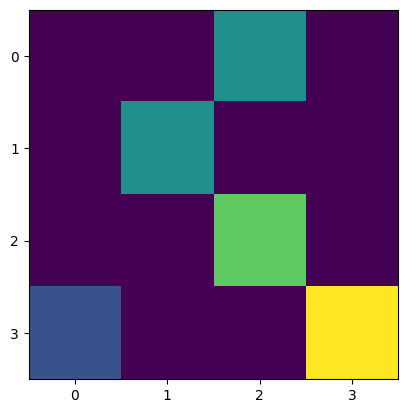

In [201]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    action1 = choose_action(state1,epsilon)
    reward_val = 0
 
    while t < max_steps:
        # #Visualizing the training
        # env.render()
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
 
        #choose next action
        action2 = choose_action(state2,epsilon)
         
        #update Q vals
        update(state1, state2, reward, action1, action2)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward
         
        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)

env.render()

Performance :  9.876
Average number of time steps :  2.956


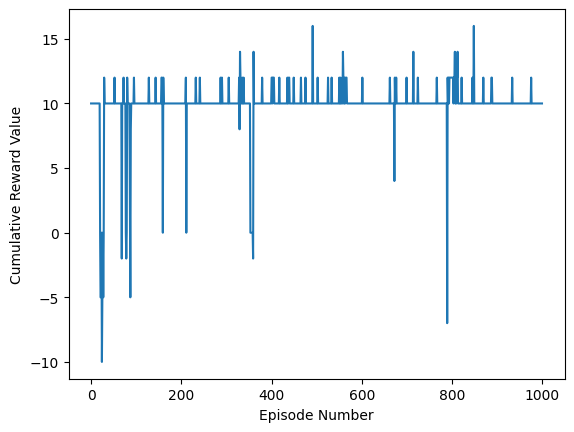

In [202]:
import matplotlib.pyplot as plt
print ("Performance : ", sum(reward_list)/episodes)
print("Average number of time steps : ", sum(time_list)/episodes)

plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

# Part 3: Solve your environment using - Q-learning

In [203]:
#Choose Action
def choose_action(state):
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state, :])
    return action

#Update Q
def update(state1, state2, reward, action):
    predict = Q[state1, action]
    target = reward + gamma * np.max(Q[state2, :])
    Q[state1, action] = Q[state1, action] + alpha * (target - predict)

In [204]:
epsilons = [0.1,0.2,0.3,0.4,0.5]
eps_decays = [0.0001,.0002,.0003,.0004,.0005]
episodes = 1000
max_steps_s = [8,9,10,11,12]
alpha = 0.85
gamma = 0.9



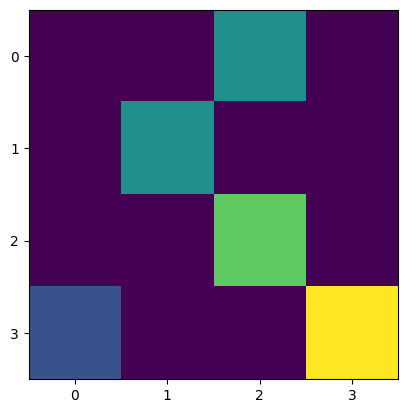

In [205]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []


best_epsilon = 0
best_eps_decay = 0
best_max_steps = 0

best_reward = 0 

#SARSA
for epsilon in epsilons:
    for eps_decay in eps_decays:
            for max_steps in max_steps_s:
                Q = np.zeros((16, 4))
                for episode in range(episodes):
                    t = 0
                    env.reset()
                    state1 = 0
                    reward_val = 0
                
                    while t < max_steps:
                        #Initialize A
                        action1 = choose_action(state1)
                        
                        #Take a time step
                        state2, reward, done, info = env.step(action1) 
                        
                        #update Q vals
                        update(state1, state2, reward, action1)

                        #keep track of current state
                        state1 = state2
                        action1 = action2
                        
                        #Updating the respective values
                        t += 1
                        reward_val += reward
                        
                        #If at the end of learning process
                        if done:
                            break
                    reward_list.append(reward_val)
                    time_list.append(t)
                    if reward_val > best_reward:
                        best_reward = reward_val
                        best_epsilon = current_eps
                        best_eps_decay = eps_decay
                        best_max_steps = max_steps
                        best_time_list = time_list

                env.render()

Performance :  8.048
Average number of time steps :  375.236
20 0.009900000000038746 0.0002 11


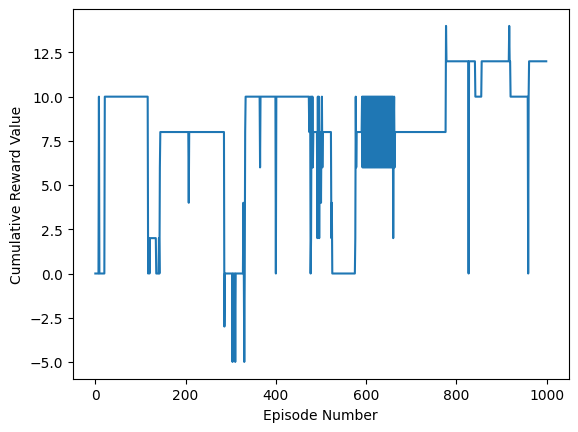

In [206]:
import matplotlib.pyplot as plt
print ("Performance : ", sum(best_reward_list)/episodes)
print("Average number of time steps : ", sum(best_time_list)/episodes)
print(best_reward,best_epsilon,best_eps_decay,best_max_steps)
plt.plot(list(range(episodes)),best_reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

In [207]:
epsilon = 0.75
episodes = 5000
max_steps = 10
alpha = 0.85
gamma = 0.9

Q = np.zeros((16, 4))

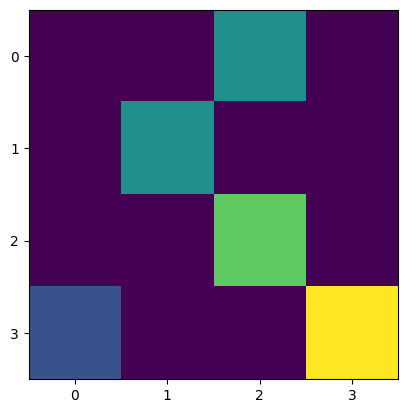

In [208]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    reward_val = 0
 
    while t < max_steps:
        #Initialize A
        action1 = choose_action(state1)
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
         
        #update Q vals
        update(state1, state2, reward, action1)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward
         
        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)

env.render()

Performance :  7.0906
Average number of time steps :  5.9844


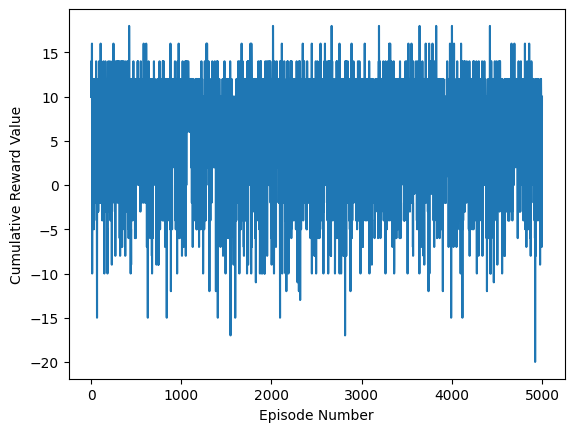

In [209]:
import matplotlib.pyplot as plt
print ("Performance : ", sum(reward_list)/episodes)
print("Average number of time steps : ", sum(time_list)/episodes)
plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

In [210]:
epsilon = 0.5
episodes = 1000
max_steps = 10
alpha = 0.5
gamma = 0.9

Q = np.zeros((16, 4))

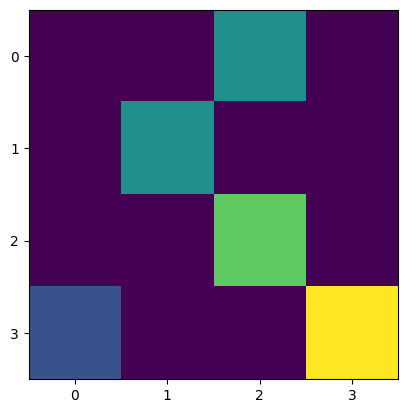

In [211]:
#Initializing the reward
reward_val=0
reward_list = []
time_list = []

#SARSA
for episode in range(episodes):
    t = 0
    env.reset()
    state1 = 0
    reward_val = 0
 
    while t < max_steps:
        #Initialize A
        action1 = choose_action(state1)
         
        #Take a time step
        state2, reward, done, info = env.step(action1)
         
        #update Q vals
        update(state1, state2, reward, action1)

        #keep track of current state
        state1 = state2
        action1 = action2
         
        #Updating the respective values
        t += 1
        reward_val += reward

        #If at the end of learning process
        if done:
            break
    reward_list.append(reward_val)
    time_list.append(t)

env.render()

Performance :  9.642
Average number of time steps :  3.811


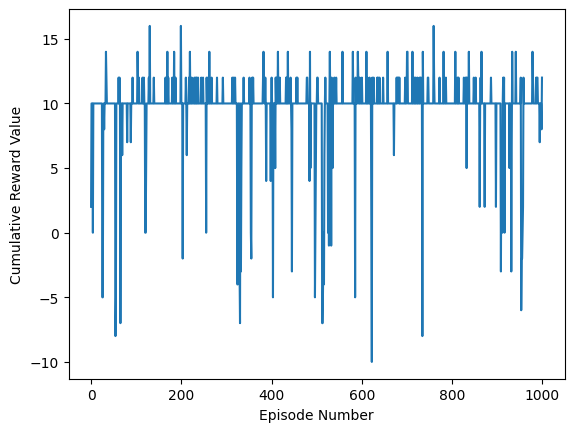

In [212]:
import matplotlib.pyplot as plt
print ("Performance : ", sum(reward_list)/episodes)
print("Average number of time steps : ", sum(time_list)/episodes)
plt.plot(list(range(episodes)),reward_list)
plt.xlabel("Episode Number")
plt.ylabel("Cumulative Reward Value")
plt.show()

In [213]:
print('goodbye world!')

goodbye world!
